In [1]:
%matplotlib inline

import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from itertools import combinations

from data import (create_hom_poisson,
                  create_hawkes,
                  create_inhom_poisson,
                  create_inhom_poisson_gauss_kernels,
                  IntensitySumGaussianKernel)
from TT_metric import (nearest_neighbor,
                       partial_optimal_assignment,
                       assignment_to_transport_plan,
                       approximate_transport_plan,
                       plot_transport_plan_approxs,
                       plot_exact_transport_plan_and_assignment,
                       plot_intens_funcs,
                       calculate_MAPEs_between_exact_approx_TT)

## Approximation of the TT-metric

The transport-transform-metric (TT-metric) assigns a distance between realizations of point processes.

In the case of temporal point processes, given two sequences $\xi = (t_1, \dots, t_m)$ and $\eta = (s_1, \dots, s_n)$ on the finite interval $[0, T]$, the TT-metric $d^\ast(\xi, \eta)$ of order $r \geq 1$ between $\xi$ and $\eta$ (assume $m \leq n$) can be formulated by the optimal transport problem
$$
d^\ast(\xi, \eta)^r =  n \cdot  \min_{P \in \Gamma_n} \sum_{i,j = 1}^n P_{ij} C_{ij}
$$
where
*   $C \in \mathbb{R}_{\geq 0}^{n \times n}$ is the cost matrix given by 
$$
C_{ij} = \begin{cases} \lvert t_i - s_j \rvert^r &\text{for $(i,j) \in \{1, \dots, m\} \times \{1, \dots, n\}$}\\
(T/2)^r &\text{else,}\\  \end{cases}
$$
where $T/2$ denotes the penalty associated to unmatched elements between $\xi$ and $\eta$,
*   $\Gamma_n = \{ P \in \mathbb{R}_{\geq 0}^{n \times n} \mid P 1_n = \frac{1}{n} 1_n, P^T 1_n = \frac{1}{n} 1_n \}$ is the set of transport plans corresponding to the cost matrix $C$ and the empirical distributions $\widehat{\xi} = \frac{1}{m} \sum_{i=1}^m \delta_{t_i} $ and $\widehat{\eta} = \frac{1}{n} \sum_{i=1}^n \delta_{s_i} $.

Consequently, we can use the Sinkhorn distance algorithm or IPOT algorithm to approximate the TT-metric between $\xi$ and $\eta$ as given by the above optimal transport problem.

The TT-metric (of order 2) can furthermore be calculated exactly by the so-called partial optimal assignment (POA) algorithm where the optimal transport plan corresponds to an an assignment (permutation matrix) from the elements of the shorter sequence $\xi$ to the elements of the longer sequence $\eta$. We consequently use the POA-algorithm as the ground-truth for the assessment the approximations.

### Visualize transport plan approximations

In the first analysis we visualize the transport plan approximations corresponding to the TT-metric approximation by the Sinkhorn distance algorithm and the IPOT algorithm. We compare the transport plans approximations to the exact transport plan corresponding to the permutation matrix solution given by the POA-algorithm.

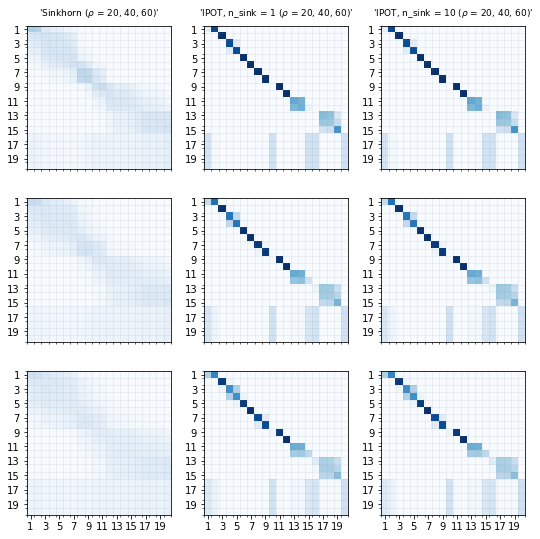

In [2]:
# define the sequences whose TT-metric we approximate (X has to be the shorter sequence)
X = [1.94,  5.26,  6.12,  6.83,  7.71,  9.68, 11.85, 12.23, 18.57, 20.21, 21.86, 22.66, 25.86, 26.01, 26.43]
Y = [1.25,  1.75,  4.5 ,  5.52,  5.81,  6.75,  7.92, 12.9 , 14.55, 17.02, 17.82, 21.48, 22.67, 22.68, 23.42, 24.74, 26.13, 26.15, 26.33, 28.03]
X_len = 15
Y_len = 20

max_seq_len = max(len(X), len(Y))
max_T = 30
penalty = max_T/2  # penalty for unmatched points in Sinkhorn and IPOT algorithm


# plot transport plan approximations of Sinkhorn distance algorithm and IPOT algorithm
# for different regularization parameters and different number of inner iterations (IPOT algorithm)
main_iters = 200 # number of main iterations in each algorithm
reg_params_list = [20, 40, 60] # regularization parameters in both algorithms
algo_list = [{"algo": "sink", "n_sink": main_iters, "n_ipot": None},
             {"algo": "ipot", "n_sink": 1,          "n_ipot": main_iters},
             {"algo": "ipot", "n_sink": 10,         "n_ipot": main_iters}]

plot_transport_plan_approxs(X, Y, max_T, algo_list=algo_list, reg_params_list=reg_params_list, main_iters=main_iters, size=3)

C:\Users\Ricardo\AppData\Roaming\Sublime Text 3\Packages\User\GenTPP\TT_metric.py:289: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axs[1].annotate(s='', xy=(Y[optimal_assignment[i]],-1), xytext=( X[i],1), arrowprops=dict(arrowstyle='->'), fontsize =20)


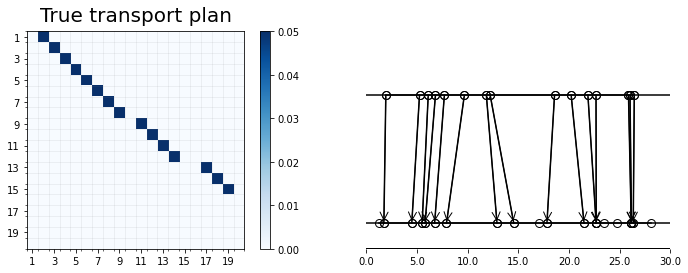

In [3]:
# plot exact transport plan as given by permutation matrix solution of POA algorithm
# also plot the corresponding assignment of elements from shorter sequence to larger sequence
plot_exact_transport_plan_and_assignment(X, Y, max_T, print_assignment=False, size=4)

### Investigate numerical approximation to TT-metric

In the second analysis we approximate the TT-metric by the Sinkhorn distance algorithm and the IPOT algorithm for 100 pairs of sequences and compare the approximation to the exact TT-metric value for each pair in terms of the mean absolute percentage error (MAPE).

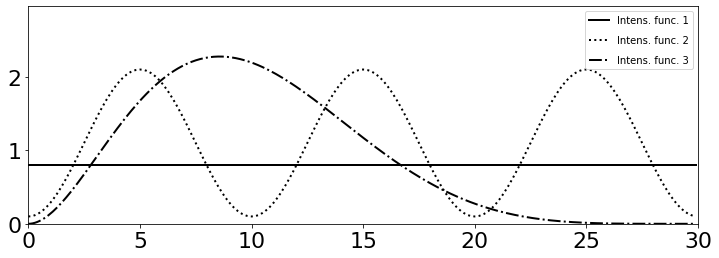

In [5]:
# create samples from three different inhom. point processes yielding three unique pairings between the samples
max_T = 30

# define and plot intensity functions of three inhom. Poisson processes
x = sy.Symbol("x")
intens_func_1 = 0.8 + 0.000000000000000000001*x    # x has to appear in function expression...
intens_func_2 = 1.1 + sy.sin(sy.pi*(x)/5 - sy.pi/2)
intens_func_3 = 150*(x/30)**2 * (1-(x/30))**5

plot_intens_funcs(list_intens_funcs=[intens_func_1, intens_func_2, intens_func_3], max_T=max_T)

In [6]:
# calculate MAPE between exact TT-metric values and its approximations by the algorithms
# perform calculation of MAPE for all unique pairs of the samples (each sample pair yielding 100 sequence pairs)
max_T = 30
penalty = max_T/2 # penalty of TT-metric
n_samples = 100

# generate samples
sequences_1 = create_inhom_poisson(func_expr = intens_func_1, n_samples=n_samples, max_T=30)
sequences_2 = create_inhom_poisson(func_expr = intens_func_2, n_samples=n_samples, max_T=30)
sequences_3 = create_inhom_poisson(func_expr = intens_func_3, n_samples=n_samples, max_T=30)

sequences_list = [sequences_1, sequences_2, sequences_3]

# specify algorithms for the TT-metric approximation and a list of regularization parameters
rho_list  = [20, 40, 60]
algo_list = [{"algo": "sink", "n_sink": main_iters, "n_ipot": None,       "reg_params": rho_list},
             {"algo": "ipot", "n_sink": 1,          "n_ipot": main_iters, "reg_params": rho_list},
             {"algo": "ipot", "n_sink": 10,         "n_ipot": main_iters, "reg_params": rho_list}]
iters     = 50 # number of main iterations in algorithms

calculate_MAPEs_between_exact_approx_TT(sequences_list=sequences_list, algo_list=algo_list, iters=500, max_T=max_T, penalty=penalty)

Calculate MAPEs for sequences 1 and 2.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                         (0.07307, 0.13481, 0.19048)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00028, 0.00053, 0.0009)
MAPEs with IPOT algorithm with 10 Sinkhorn iterations (rho = (20, 40, 60)): (0.00021, 0.00053, 0.00089)


Calculate MAPEs for sequences 1 and 3.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                         (0.05436, 0.10275, 0.14388)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00018, 0.00035, 0.00057)
MAPEs with IPOT algorithm with 10 Sinkhorn iterations (rho = (20, 40, 60)): (0.00014, 0.00034, 0.00057)


Calculate MAPEs for sequences 2 and 3.
MAPEs with Sinkhorn algorithm (rho = (20, 40, 60)):                         (0.05447, 0.10753, 0.15443)
MAPEs with IPOT algorithm with  1 Sinkhorn iterations (rho = (20, 40, 60)): (0.00059, 0.00045, 0.00065)
MAPEs with IPOT algorithm with 10 Sinkhorn itera